In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


tqdm.pandas()

In [2]:
train = pd.read_csv("../../dataset/processed/cleanDataset.csv", index_col=0)
test = pd.read_csv("../../dataset/processed/cleanTest.csv", index_col=0)

train.head()

,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,damage_grade
0,2,1.0,17.0688,22.0,Flat,bamboo or timber,bamboo/timber light roof,clay,timber/bamboo-mud,Not attached,...,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,Unknown/not stated,Unknown/not stated,1.0
1,3,3.0,300.2280,18.0,Flat,clay sand mixed mortar-stone/brick,wood light roof or bamboo heavy roof,clay,timber/bamboo-mud,Not attached,...,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,"Mud + Mortar,Clay",Stone Bricks,5.0
3,2,18.0,56.3880,15.0,Flat,clay sand mixed mortar-stone/brick,wood light roof or bamboo light roof,clay,timber/bamboo-mud,Not attached,...,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,"Mud + Mortar,Clay",Stone Bricks,4.0
4,2,22.0,27.4320,17.0,Flat,clay sand mixed mortar-stone/brick,bamboo or timber light roof,clay,timber/bamboo-mud,Not attached,...,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,"Mud + Mortar,Clay",Stone Bricks,1.0
7,2,40.0,153.6192,14.0,Flat,clay mortar-stone/brick,bamboo/timber light roof,clay,timber/bamboo-mud,Not attached,...,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,"Mud + Mortar,Clay",Stone Bricks,4.0


In [3]:
dict_type_of_roof = {
    "bamboo/timber-heavy roof": "bamboo/timber heavy roof",
    "bamboo or timber light roof": "bamboo/timber-light roof",
    "bamboo/timber light roof ": "bamboo/timber-light roof",
    "bamboo or timber heavy roof": "bamboo/timber heavy roof",
    "bamboo/timber light roof": "bamboo/timber-light roof",
    "reinforced brick concrete/rcc/rbc": "reinforced cement concrete/rb/rbc"
}

train["type_of_roof"].replace(dict_type_of_roof, inplace=True)
test["type_of_roof"].replace(dict_type_of_roof, inplace=True)

In [4]:
train["type_of_roof"].value_counts()

bamboo/timber-light roof                139695
wood light roof or bamboo heavy roof     70095
wood light roof or bamboo light roof     59880
reinforced cement concrete/rb/rbc        15116
bamboo/timber heavy roof                 14353
reinforced brick slab/rcc/rbc             2468
Name: type_of_roof, dtype: int64

In [5]:
train.shape

(301607, 24)

## FE

In [6]:
from sklearn.model_selection import train_test_split

objectCol = list(train.select_dtypes(include=['object']).columns)
numCol = list(train.select_dtypes(exclude=['object']).columns)[:-1]

X = train.iloc[:, :-1]
y = train.iloc[:, -1]
y -= 1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
numeric_features = numCol
categorical_features = objectCol
numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(OneHotEncoder())
Preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transformer, numeric_features),
        ('categorical_transformer', categorical_transformer, categorical_features)
    ])

In [8]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)
X_train = Preprocessor.fit_transform(X_rus)
X_test = Preprocessor.transform(X_test)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

r = RandomForestClassifier(random_state=42, n_jobs=6)
r.fit(X_train, y_rus)

y_pred = r.predict(X_test)
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

F1 score: 0.8035372366954363


In [10]:
import optuna

def r_objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 300),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
    }
    
    r = RandomForestClassifier(**params, random_state=42, n_jobs=6)
    r.fit(X_train, y_rus)
    
    y_pred = r.predict(X_test)
    
    return f1_score(y_test, y_pred, average='macro')

r_study = optuna.create_study(direction="maximize")
r_study.optimize(r_objective, n_trials=100, n_jobs=6, show_progress_bar=True, timeout=600)

[I 2023-04-15 22:03:39,001] A new study created in memory with name: no-name-b029646d-f872-464c-bb82-c0e85f942e03
[I 2023-04-15 22:04:28,518] Trial 1 finished with value: 0.8126922911792551 and parameters: {'n_estimators': 77, 'max_depth': 77, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.8126922911792551.
[I 2023-04-15 22:04:42,439] Trial 4 finished with value: 0.8113819592461627 and parameters: {'n_estimators': 136, 'max_depth': 35, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.8126922911792551.
[I 2023-04-15 22:05:03,168] Trial 6 finished with value: 0.8119349329795916 and parameters: {'n_estimators': 35, 'max_depth': 55, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8126922911792551.
[I 2023-04-15 22:05:09,390] Trial 2 finished with value: 0.814971472375527 and parameters: {'n_estimators': 89, 'max_depth': 94, 'min_s

In [11]:
r_study.best_params

{'n_estimators': 89,
 'max_depth': 94,
 'min_samples_split': 8,
 'min_samples_leaf': 5,
 'max_features': 'auto'}

In [12]:
r_selected_features = pd.DataFrame(
    r.feature_importances_, index=np.arange(0, 111), columns=['importance'])
r_selected_features.sort_values(by='importance', ascending=False, inplace=True)


In [14]:
r_selected_features

,importance
55,0.169737
58,0.151458
56,0.150937
57,0.140821
2,0.083946
...,...
45,0.000006
75,0.000002
79,0.000002
72,0.000001


In [15]:
sweet_spot = {}

params = {'n_estimators': 89,
     'max_depth': 94,
     'min_samples_split': 8,
     'min_samples_leaf': 5,
     'max_features': 'auto'
     }

for i in range(1, 112):
    X_train_selected = X_train.toarray()[:, r_selected_features[:i].index]
    X_test_selected = X_test.toarray()[:, r_selected_features[:i].index]

    x = RandomForestClassifier(**params, random_state=42, n_jobs=6)
    x.fit(X_train_selected, y_rus)

    y_pred = x.predict(X_test_selected)
    skor = f1_score(y_test, y_pred, average='macro')
    print(f"{i} fitur teratas : {skor}")
    sweet_spot[i] = skor

1 fitur teratas : 0.31604872154234104
2 fitur teratas : 0.47354441060718944
3 fitur teratas : 0.7288954247307974
4 fitur teratas : 0.7288954247307974
5 fitur teratas : 0.7846695197003071
6 fitur teratas : 0.7815380923636847
7 fitur teratas : 0.7890145212932319
8 fitur teratas : 0.79321190737843
9 fitur teratas : 0.794992583572815
10 fitur teratas : 0.7957537103048806
11 fitur teratas : 0.7985817922542763
12 fitur teratas : 0.7997944704630144
13 fitur teratas : 0.8003513564643431
14 fitur teratas : 0.8019797513823255
15 fitur teratas : 0.8008832004613918
16 fitur teratas : 0.8013805702093292
17 fitur teratas : 0.8029437507451789
18 fitur teratas : 0.8019290317102199
19 fitur teratas : 0.8036939539741772
20 fitur teratas : 0.8028423574502147
21 fitur teratas : 0.8026061931473534
22 fitur teratas : 0.8026438741257002
23 fitur teratas : 0.8040274893063476
24 fitur teratas : 0.803326179622807
25 fitur teratas : 0.8039797852122443
26 fitur teratas : 0.8046774929246261
27 fitur teratas : 0.80

<Axes: ylabel='f1_score'>

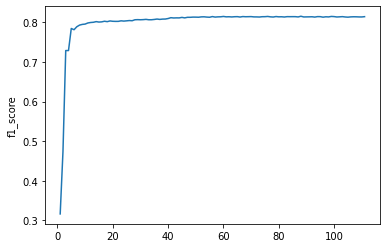

In [17]:
sweet_spot = pd.DataFrame.from_dict(sweet_spot, orient='index', columns=['f1_score'])
sweet_spot.sort_values(by='f1_score', ascending=False, inplace=True)

sns.lineplot(x=sweet_spot.index, y=sweet_spot.f1_score)

In [18]:
sweet_spot.head(10)

,f1_score
88,0.815585
99,0.815093
76,0.815069
60,0.815051
79,0.814829
67,0.814766
56,0.814743
70,0.814672
100,0.814663
94,0.814639


In [19]:
from collections import Counter

In [20]:
X_train_selected = X_train.toarray()[:, r_selected_features[:88].index]
X_test_selected = X_test.toarray()[:, r_selected_features[:88].index]

r_tuned = RandomForestClassifier(**params, random_state=42, n_jobs=6)
r_tuned.fit(X_train_selected, y_rus)

y_pred = r_tuned.predict(X_test_selected)

print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

F1 score: 0.8155851446694757


In [22]:
submit_df = Preprocessor.transform(test)
submit_df = submit_df.toarray()[:, r_selected_features[:88].index]
y_pred_sub = r_tuned.predict(submit_df)

Counter(y_pred_sub).most_common()

[(4.0, 83097), (3.0, 66248), (2.0, 41218), (1.0, 35119), (0.0, 16400)]

In [23]:
submission = pd.read_csv("../../dataset/raw/sample_submission.csv")
submission["damage_grade"] = y_pred_sub + 1
submission["damage_grade"] = submission["damage_grade"].astype(int)
submission.head()

,id,damage_grade
0,0,4
1,1,5
2,2,5
3,3,4
4,4,2


In [107]:
submission.to_csv("../../dataset/submission_rf_feat_select_tuned_BISMILLAH YA ALLAH.csv", index=False)